# Import Library

In [2]:
import os
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

# Download and Extract Dataset

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# local_zip = '/content/dataset.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content')
# zip_ref.close()

base_dir = 'image/'

In [5]:
os.listdir(base_dir)

['bopeng', 'jerawat', 'komedo', 'normal']

In [6]:
file_name = []
tag = []
full_path = []

for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split("/")[-1])
        file_name.append(name)


In [7]:
df = pd.DataFrame({"path": full_path, "file_name": file_name, "tag": tag})
df.groupby(["tag"]).size()


tag
bopeng      936
jerawat    1164
komedo      841
dtype: int64

In [8]:
df.head(10)

,path,file_name,tag
0,image/bopeng\bopeng_0_1005.jpg,bopeng_0_1005.jpg,bopeng
1,image/bopeng\bopeng_0_101.jpg,bopeng_0_101.jpg,bopeng
2,image/bopeng\bopeng_0_1011.jpg,bopeng_0_1011.jpg,bopeng
3,image/bopeng\bopeng_0_1015.jpg,bopeng_0_1015.jpg,bopeng
4,image/bopeng\bopeng_0_1023.jpg,bopeng_0_1023.jpg,bopeng
5,image/bopeng\bopeng_0_1030.jpg,bopeng_0_1030.jpg,bopeng
6,image/bopeng\bopeng_0_1031.jpg,bopeng_0_1031.jpg,bopeng
7,image/bopeng\bopeng_0_1033.jpg,bopeng_0_1033.jpg,bopeng
8,image/bopeng\bopeng_0_1035.jpg,bopeng_0_1035.jpg,bopeng
9,image/bopeng\bopeng_0_1060.jpg,bopeng_0_1060.jpg,bopeng


In [9]:
X = df["path"]
y = df["tag"]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123, stratify=y)

In [11]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=42)

In [12]:
data_train = pd.DataFrame({"path": X_train, "tag": y_train, "set": "train"})
data_valid = pd.DataFrame({"path": X_val, "tag": y_val, "set": "valid"})
data_test = pd.DataFrame({"path": X_test, "tag": y_test, "set": "test"})


In [13]:
print("train size", len(data_train))
print("val size", len(data_valid))
print("test size", len(data_test))


train size 2352
val size 295
test size 294


In [14]:
# Melihat proporsi training dan validation set
df_all = data_train.append([data_valid, data_test]).reset_index(drop=1)
print(df_all.groupby(["set", "tag"]).size(), "\n")

# Cek sample data
df_all.sample(3)

set    tag    
test   bopeng      87
       jerawat    126
       komedo      81
train  bopeng     748
       jerawat    931
       komedo     673
valid  bopeng     101
       jerawat    107
       komedo      87
dtype: int64 



C:\Users\User\AppData\Local\Temp\ipykernel_9000\3325083987.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = data_train.append([data_valid, data_test]).reset_index(drop=1)


,path,tag,set
722,image/jerawat\jerawat_0_3268.jpg,jerawat,train
1982,image/jerawat\jerawat_0_8164.jpg,jerawat,train
40,image/komedo\komedo_0_7258.jpg,komedo,train


In [15]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)


In [16]:
train_generator = train_datagen.flow_from_dataframe(
        data_train,
        x_col="path",
        y_col="tag",
        target_size=(200, 200),
        batch_size=235,
        class_mode="categorical",
        shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
        data_valid,
        x_col="path",
        y_col="tag",
        target_size=(200, 200),
        batch_size=29,
        class_mode="categorical",
        shuffle=True
)

test_generator = train_datagen.flow_from_dataframe(
        data_test,
        x_col="path",
        y_col="tag",
        target_size=(200, 200),
        batch_size=29,
        class_mode="categorical",
        shuffle=True
)

Found 2352 validated image filenames belonging to 3 classes.
Found 295 validated image filenames belonging to 3 classes.
Found 294 validated image filenames belonging to 3 classes.


In [17]:
# def tf_data_generator(generator, input_shape):
#     num_class = generator.num_classes
#     tf_generator = tf.data.Dataset.from_generator(
#         lambda: generator,
#         output_types=(tf.float32, tf.float32),
#         output_shapes=(
#             [None, input_shape[0], input_shape[1], input_shape[2]],
#             [None, num_class],
#         ),
#     )
#     return tf_generator


# train_data = tf_data_generator(train_generator, (150,150))
# test_data = tf_data_generator(test_generator, (150,150))
# val_data = tf_data_generator(validation_generator, (150,150))

# Callback Function

In [18]:
ACCURACY_THRESHOLD = 0.99


class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") > ACCURACY_THRESHOLD:
            print(
                "\nReached %2.2f%% accuracy, training stopped!"
                % (ACCURACY_THRESHOLD * 100)
            )
            self.model.stop_training = True


callbacks = Callback()

# Building Model

In [19]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(200, 200, 3)
        ),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(3, activation="softmax"),
    ]
)


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

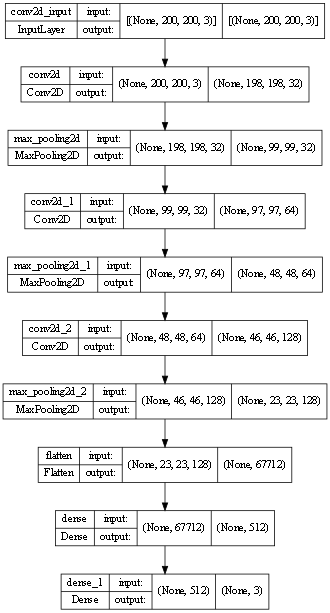

In [21]:
model_viz = tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=55,
)
model_viz

In [22]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


In [23]:
history = model.fit(
      train_generator,
      steps_per_epoch=10,
      epochs=50,
      verbose=2,
      validation_data=validation_generator,
      validation_steps=10,
      callbacks=[callbacks],
)


Epoch 1/50
10/10 - 49s - loss: 2.2162 - accuracy: 0.3821 - val_loss: 0.9848 - val_accuracy: 0.6000 - 49s/epoch - 5s/step
Epoch 2/50
10/10 - 49s - loss: 1.0661 - accuracy: 0.4771 - val_loss: 0.9427 - val_accuracy: 0.4931 - 49s/epoch - 5s/step
Epoch 3/50
10/10 - 62s - loss: 0.8111 - accuracy: 0.6089 - val_loss: 0.6815 - val_accuracy: 0.7345 - 62s/epoch - 6s/step
Epoch 4/50
10/10 - 63s - loss: 0.7599 - accuracy: 0.6608 - val_loss: 0.6155 - val_accuracy: 0.7966 - 63s/epoch - 6s/step
Epoch 5/50
10/10 - 68s - loss: 0.7179 - accuracy: 0.6835 - val_loss: 0.7249 - val_accuracy: 0.7793 - 68s/epoch - 7s/step
Epoch 6/50
10/10 - 76s - loss: 0.5387 - accuracy: 0.7922 - val_loss: 0.8272 - val_accuracy: 0.6759 - 76s/epoch - 8s/step
Epoch 7/50
10/10 - 70s - loss: 0.5465 - accuracy: 0.7804 - val_loss: 0.6279 - val_accuracy: 0.7793 - 70s/epoch - 7s/step
Epoch 8/50
10/10 - 70s - loss: 0.4178 - accuracy: 0.8531 - val_loss: 0.5430 - val_accuracy: 0.8655 - 70s/epoch - 7s/step
Epoch 9/50
10/10 - 60s - loss: 0

# Model Accuracy

In [24]:
test_loss, test_acc = model.evaluate(test_generator)
print("\naccuracy:", test_acc, "  loss: ", test_loss)


11/11 [==============================] - 3s 269ms/step - loss: 0.6010 - accuracy: 0.8878

accuracy: 0.8877550959587097   loss:  0.6010256409645081


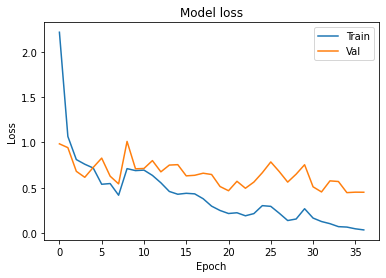

In [25]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper right")
plt.show()

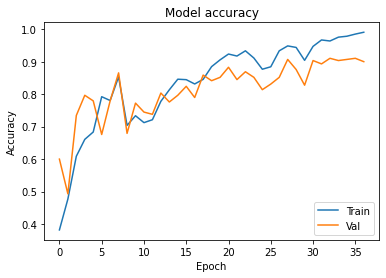

In [26]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="lower right")
plt.show()

# Making Prediction

[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]


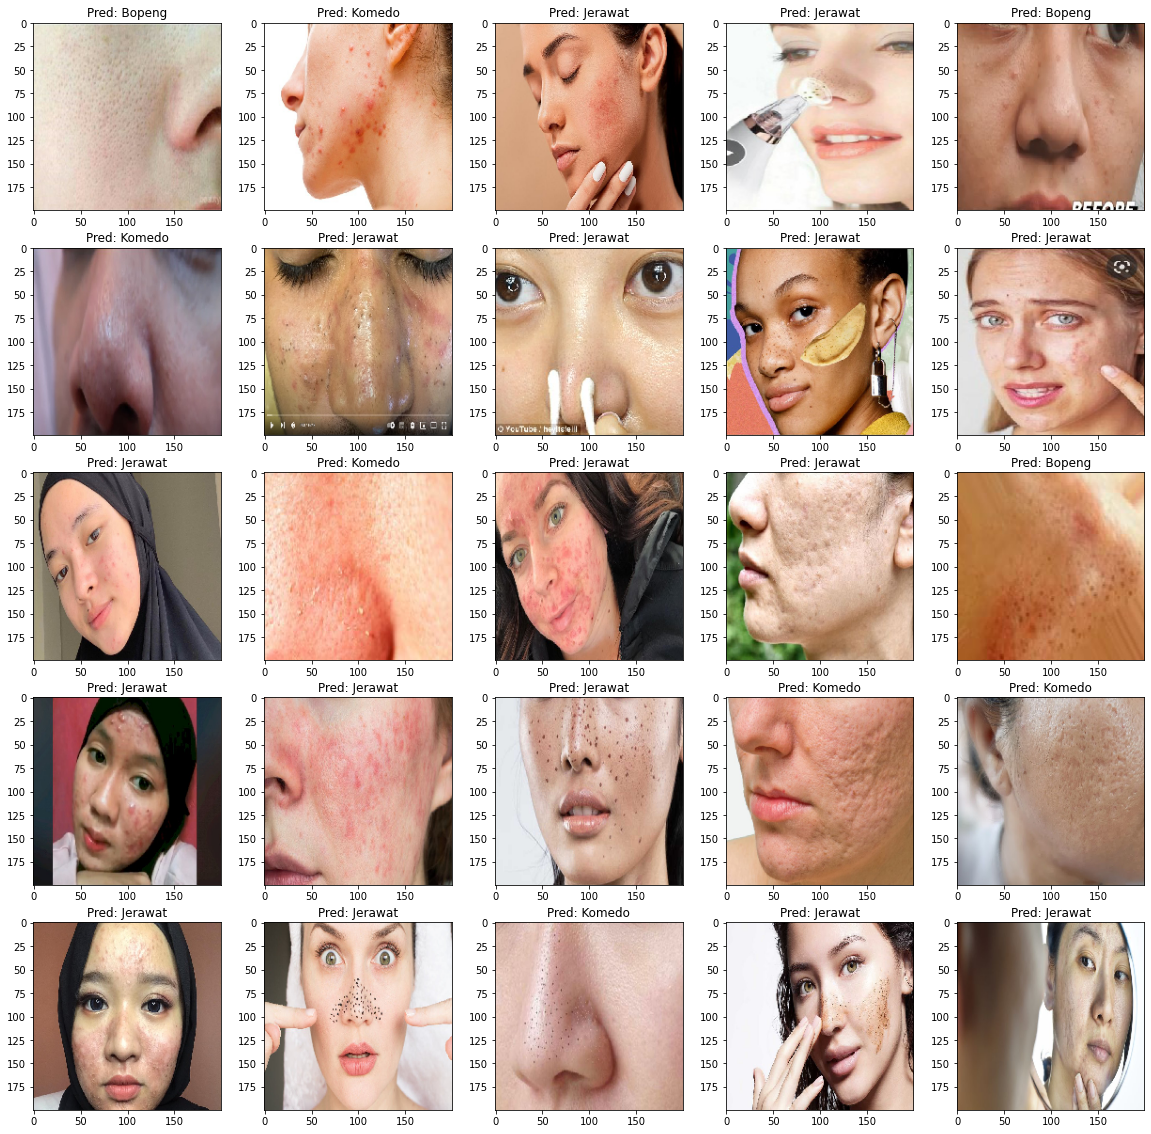

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

m = 1
columns = 5
rows = 5
directory = 'test'
pred_labels = ""
# iterate over files in
# that directory
fig = plt.figure(figsize=(20, 20))
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        img = image.load_img(f, target_size=(200, 200))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])
        classes = model.predict(images, batch_size=10)
        print(classes[0])
        if classes[0,0]!=0:
            pred_labels = 'Bopeng'
        elif classes[0,1]!=0:
            pred_labels = 'Jerawat'
        else:
            pred_labels = 'Komedo'
            
        fig.add_subplot(rows, columns, m)
        plt.imshow(img)
        plt.title("Pred: " + pred_labels)
        m += 1

In [28]:
preds = np.round(model.predict(test_generator), 0)
print(preds)

[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0.

In [29]:
num_classes = len(test_generator.class_indices)
test_labels = test_generator.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [30]:
faces = ['bopeng', 'jerawat', 'komedo']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=faces)
print(classification_metrics)

              precision    recall  f1-score   support

      bopeng       0.28      0.26      0.27        87
     jerawat       0.41      0.40      0.40       126
      komedo       0.27      0.30      0.28        81

   micro avg       0.33      0.33      0.33       294
   macro avg       0.32      0.32      0.32       294
weighted avg       0.33      0.33      0.33       294
 samples avg       0.33      0.33      0.33       294



c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Save the Model

In [32]:
MODEL_BASE_PATH = "model"
PROJECT_NAME = "ausion_project"
SAVE_MODEL_NAME = "ausion.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print("Saving Model At {}...".format(save_model_path))
model.save(save_model_path, include_optimizer=False)


Saving Model At model\ausion_project\ausion.h5...
